In [1]:
import numpy
import astropy
import pylab as pl
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import pandas as pd

from photutils import datasets
from astropy.io import fits
from astropy.visualization import simple_norm
from photutils import aperture_photometry, CircularAperture
from photutils import DAOStarFinder
from astropy.stats import mad_std
from astropy import wcs
from astropy.wcs import WCS
from astropy.stats import mad_std

import glob
import math
import os

# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:

sci_fn = '/Users/mbutner/github/IRTF_SpeX_QuickReduce/data/practice/arc71-test.b.fits'
sci_hdulist = fits.open(sci_fn)

# Define the data array
data = sci_hdulist[0].data.astype(np.float32)

# Extract the data header and create a WCS object.
from astropy.wcs import WCS

hdr = sci_hdulist[0].header
wcs = WCS(hdr)

print()
print("printing wcs header")
print(wcs)
print()


printing wcs header
WCS Keywords

Number of WCS axes: 2
CTYPE : ''  ''  
CRVAL : 0.0  0.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.0  1.0  
NAXIS : 2048  2048



Min: -1891
Max: 77036
Mean: 146.08758568763733
Stdev: 1893.5170937162347


Text(0.5, 1.0, 'hd76151-00177.a.fits:  Background-subtracted 2D Spectrum, Rows 905+/-50')

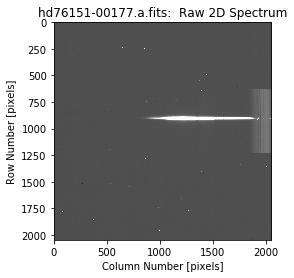

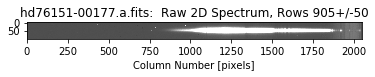

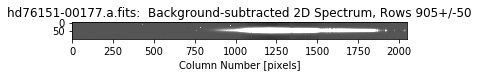

In [17]:
# SpeX configuration info...
# Typically change nightly or whenever there has been a configuration change:
#  Grating:
dispersion_nonbinned = {400:1.0, 600:0.65, 930:0.42, 1200:0.31, 1800:0.19, 2100:0.15, 2400:0.12}
grating = 400      # Integer value

#  Binning in wavelength direction (e.g., binSize_wave = 2 for 2x2 binning):
binSize_wave = 2   # Integer value

# column pixel value (col1) and corresponding wavelength (wave1) 
#  for an identified line in wavecal comparison lamp spectrum:
col1 = 1170.       # In pixels
wave1 = 1048.  # In Angstroms (5460.7348)

# Effective dispersion for this grating and binning...
dispersion = binSize_wave*dispersion_nonbinned[grating]
# Wavelength corresponding to spectrum bin 0:
wavelength0 = wave1 - dispersion*col1  # Will typically be around 3100 for "400_WD" configuration 


# Target spectrum info...
# Typically change per target...
t_inputFile='/Users/mbutner/Downloads/jup-00107.a.fits'
#  Center row along which the target object's spectrum lies within t_inputFile:
t_aper_row_center = 475

ss_delta_aper_row = 5    # Integer value
ss_delta_plot_row = 50   # Integer value
ss_aper_row_center = 905  # Integer value 
ssFile_short = 'f110.dat' 
#ss_inputFile = '/Users/mbutner/github/IRTF_SpeX_QuickReduce/data/practice/0129_feige110.fits'
ss_inputFile = '/Users/mbutner/Downloads/hd76151-00177.a.fits'
inputFile = ss_inputFile
outputFile = ss_inputFile+'.calib.csv'

aper_row_min = ss_aper_row_center - ss_delta_aper_row
aper_row_max = ss_aper_row_center + ss_delta_aper_row
small_plot_row_min = ss_aper_row_center - ss_delta_plot_row
small_plot_row_max = ss_aper_row_center + ss_delta_plot_row

image_data = fits.getdata(inputFile)

print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))

vmin = np.mean(image_data) - np.std(image_data)
vmax = np.mean(image_data) + 2.*np.std(image_data)

plt.figure(1)
plt.imshow(image_data, cmap='gray', vmin=vmin, vmax=vmax)
plt.xlabel("Column Number [pixels]")
plt.ylabel("Row Number [pixels]")
title="""%s:  Raw 2D Spectrum""" % (os.path.basename(inputFile))
plt.title(title)

plt.figure(2)
plt.imshow(image_data[small_plot_row_min:small_plot_row_max,:], 
           cmap='gray', vmin=vmin, vmax=vmax)
plt.xlabel("Column Number [pixels]")
title="""%s:  Raw 2D Spectrum, Rows %d+/-%d""" % \
    (os.path.basename(inputFile), ss_aper_row_center, ss_delta_plot_row)
plt.title(title)

median1d = np.median(image_data[small_plot_row_min:small_plot_row_max,:],axis=0)

bkg_data = np.tile(median1d,[2048,1])

new_image_data = image_data - bkg_data

vmin = 0.00 - np.std(image_data)
vmax = 0.00 + 2.*np.std(image_data)

plt.figure(3)
plt.imshow(new_image_data[small_plot_row_min:small_plot_row_max,:], 
           cmap='gray', vmin=vmin, vmax=vmax)
plt.xlabel("Column Number [pixels]")
title="""%s:  Background-subtracted 2D Spectrum, Rows %d+/-%d""" % \
    (os.path.basename(inputFile), ss_aper_row_center, ss_delta_plot_row)
plt.title(title)

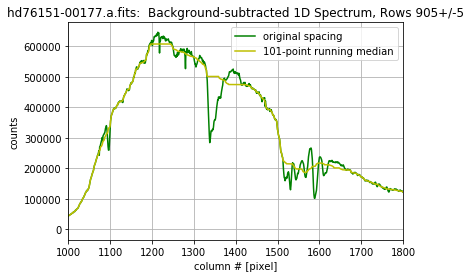

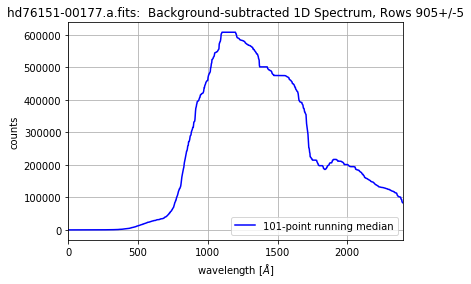

In [18]:

sum1d = np.sum(new_image_data[aper_row_min:aper_row_max,:],axis=0)

#x=np.arange(0,2071)
x=np.arange(0,sum1d.size)

# Running median...
x_series = pd.Series(x, name='x')
sum1d_series = pd.Series(sum1d, name='counts')
df_sum1d = pd.concat([x_series,sum1d_series], axis=1)
df_sum1d.loc[:,'wavelength'] = dispersion*df_sum1d.loc[:,'x'] + wavelength0
wave = df_sum1d.wavelength.values
df_sum1d_smoothed = df_sum1d.rolling(101).median().dropna()
x_smoothed = df_sum1d_smoothed.x.values
wave_smoothed = df_sum1d_smoothed.wavelength.values
sum1d_smoothed = df_sum1d_smoothed.counts.values


plt.figure(4)
plt.plot(x, sum1d, 'g-', 
         x_smoothed, sum1d_smoothed, 'y-')
plt.legend(['original spacing', 
            '101-point running median'], 
           loc='best')
plt.xlabel("""column # [pixel]""")
plt.ylabel("counts")
plt.xlim([1000,1800])
title="""%s:  Background-subtracted 1D Spectrum, Rows %d+/-%d""" % \
    (os.path.basename(inputFile), ss_aper_row_center, ss_delta_aper_row)
plt.title(title)
plt.grid(True)

plt.figure(5)
plt.plot(wave_smoothed, sum1d_smoothed, 'b-')
plt.legend(['101-point running median'], 
           loc='best')
plt.xlabel("""wavelength [$\AA$]""")
plt.ylabel("counts")
plt.xlim([0,2400])
title="""%s:  Background-subtracted 1D Spectrum, Rows %d+/-%d""" % \
    (os.path.basename(inputFile), ss_aper_row_center, ss_delta_aper_row)
plt.title(title)
plt.grid(True)